$$
\renewcommand{\R}{\mathbb{R}}
\newcommand{\b}{\mathbf}
\renewcommand{\u}{\mathbf{u}}
\renewcommand{\v}{\mathbf{v}}
$$

# Movie Recommendations

| user  | Moonlight | The Shape of Water | Frozen | Moana |
| ----- | --------- | ------------------ | ------ | ----- |
| Alice | 5         | 4                  | 1      |       |
| Bob   |           | 5                  |        | 2     |
| Carol |           |                    |        | 5     |
| David |           |                    | 5      | 5     |
| Eve   | 5         | 4                  |        |       |

What movie should I recommend to Bob?
Will Carol like Frozen?

**Goal**: Fill in entries of the "rating matrix"


# Problem Setup

Let's formalize this as a machine learning problem. To make it concrete, let's load some data and see what it looks like.


In [2]:
import scipy.io
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load train and test data
data = scipy.io.loadmat('movies.mat')

titles = [t[0] for t in data['movieData']['title'][0, 0].ravel()]

for x, y in data.items():
    if isinstance(y, (np.ndarray)) and len(y) == 1:
        data[x] = y.item()
    elif isinstance(y, (np.ndarray)):
        data[x] = y.ravel()

nUsers = data['nUsers']
nMovies = data['nMovies']
userData = data['userData']
movieData = data['movieData']

train_user = data['train_user']-1   # matlab 1-index correction
train_movie = data['train_movie']-1  # matlab 1-index correction
train_rating = data['train_rating']

valid_user = data['valid_user']-1   # matlab 1-index correction
valid_movie = data['valid_movie']-1  # matlab 1-index correction
valid_rating = data['valid_rating']

test_user = data['test_user']-1    # matlab 1-index correction
test_movie = data['test_movie']-1   # matlab 1-index correction


# Create a pandas data frame for training data to facilitate
# visualization and inspection

train_title = [titles[i] for i in train_movie]

train_data = pd.DataFrame(data={'user_id': train_user,
                                'movie_id': train_movie,
                                'rating': train_rating,
                                'title': train_title},
                          columns=['user_id', 'movie_id', 'rating', 'title'])

# subsample to 5000 rows to more easily see a small sampling of ratings for each user
train_data = train_data[:5000]

# sort by user
train_data = train_data.sort_values(by=['user_id', 'rating'])

display(train_data)


,user_id,movie_id,rating,title
2070,0,242,1,Jungle2Jungle (1997)
2175,0,73,1,Faster Pussycat! Kill! Kill! (1965)
984,0,101,2,"Aristocats, The (1970)"
2400,0,236,2,Jerry Maguire (1996)
4364,0,179,3,Apocalypse Now (1979)
...,...,...,...,...
1373,942,61,3,Stargate (1994)
724,942,150,4,Willy Wonka and the Chocolate Factory (1971)
1883,942,23,4,Rumble in the Bronx (1995)
3403,942,731,4,Dave (1993)


## Training Data

As we can see, the training data presents observed entries of the "ratings" matrix as list of triples $(i_k, j_k, r_k)$ where

- $i_k$ is the user index of $k$th rating
- $j_k$ is the movie index of $k$th rating
- $r_k$ is the value of $k$th rating (1-5)

In our code we will store the entries of the tuples in three separate 1d arrays of the same length, so the $k$th rating is represented by the values `train_user[k]`, `train_movie[k]`, and `train_rating[k]`.


## Problem Formulation

Now, let's formulate the problem mathematically. Suppose there are $m$ users and $n$ movies.
Let $R$ be the $m \times n$ "rating" matrix, where $R_{ij}$ is the (possibly unknown) rating for user $i$ on movie $j$.

Our training data gives us some of the entries of the rating matrix. Our goal
is to learn a parametric model to predict entries that we don't observe.

#### But Where are the Features?

What sort of predictive model can we use for entries of $R$?

In past learning problems we had _feature vectors_ and we learned _weight vectors_ to make predictions (using dot products).

Now we do not have feature vectors. What should we do?


## Matrix Factorization Model

Our solution is to **learn weight vectors for both users and movies**.

Let $u_i$ in $R^d$ be the weight vector for user $i$ and $v_j$ in $R^d$ be the weight vector for movie $j$. Then we can predict the rating for user $i$ on movie $j$ as:

$$
H_{ij} =u_i^T v_j
$$

Our goal is to learn weight vectors for every user and movie so that $R_{ij} \approx H_{ij}$ for those entries of the rating matrix that we observe.

**Problem statement**:
Given observed entries of the rating matrix presented as triples $(i_k, j_k, r_k)$ for $k=1, \ldots, n_{\text{train}}$, find weight vectors $\mathbf{u_i}$ for each user $i$ and $\mathbf{v}_j$ for each movie $j$ such that:

$$
r_k \approx \mathbf{u_{i_k}}^T \mathbf{v_{j_k}}, \quad k=1, 2, \ldots, n_{\text{train}}
$$


## Why is This Called Matrix Factorization?

- Place the user weight vectors $u_i$ into the rows of a matrix
  $U$ and the movie feature vectors $v_j$ into
  the rows of a matrix $V$

  $$
  \newcommand{\line}{-}
  U =
      \begin{bmatrix}
          \line u_1^T \line \\
          \line u_2^T \line \\
          \ldots \\
          \line u_m^T \line \\
      \end{bmatrix} \text{in}\ \R^{m \times d}
  \qquad
  V =
      \begin{bmatrix}
          \line v_1^T \line \\
          \line v_2^T \line \\
          \ldots \\
          \line v_n^T \line \\
      \end{bmatrix} \text{in}\ \R^{n \times d}
  $$

- Consider the product $U V^T$:

  $$
  \boxed{
      \begin{array}{c}
          \\
          U \\
          \\
      \end{array}
      }
  \boxed{
      \begin{array}{c}
          \\ \\ \\ V^T \\ \\ \\
      \end{array}
      }
  $$

- It is easy to check that $(i,j)$ entry of $UV^T$ is equal to $u_i^T v_j$, which is our prediction for the $(i,j)$ entry of $R$

- In other words, our model is that $R \approx U V^T$ (a **factorization**
  of $R$)

- We choose $U$ and $V$ to get good predictions for those entries of
  $R$ that we can observe. As long as we don't overfit, this gives us
  power to generalize to entries we don't observe
- The "hidden dimension" $d$ (the length of each weight vector) is a hyperparameter
  that must be tuned with hold-out data.


## Your Job: Solve the Learning Problem

- Formulate a squared error cost function corresponding to the problem statement above.
- Add regularization for _every_ user weight vector $u_i$ and movie weight vector $v_j$ to get a regularized cost function
- Write down the partial derivatives of your regularized cost function with
  respect to the entries of $u_i$ and $v_j$
- Plug the partial derivatives into stochastic gradient descent (SGD)
  and write down the update rule
- Implement SGD
- Tune parameters (e.g., dimension $d$, regularization parameter) get good performance on the validation set


## Logistics

- Submit predictions on test set
- Evaluation: root-mean squared error (RMSE) on test set

  $$ \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}}\sum_{(i,j) \in \text{test set}} (H_{ij} - R_{ij})^2}$$

- Your grade:


| RMSE    | grade |
| ------- | ----- | --- |
| <= 1.0  | 80%   |
| <= 0.97 | 90%   |
| <= 0.95 | 95%   |
| <= 0.94 | 100%  |     |

## (Review on your own) Model Extension: Add Biases

To get really great performance, consider this extended model for a predicted rating:

$$
H_{ij} = \mu + a_i + b_j + u_i^T v_j
$$

This adds several terms to the prediction for user $i$ on movie $j$:

- $\mu$ is an overall baseline rating. For example, the overall average rating of all users
  on all movies may be $\mu = 3.3$
- $a_i$ is a user-specific adjustment or "bias". For example, perhaps Alice
  really loves movies and gives them all high ratings. Then, her bias
  might be $a_i = +0.4$. But Bob is hard to please, so his bias is $a_i = -0.7$.
- $b_j$ is a movie-specific bias. For example, perhaps Inside Out is universally
  loved, so its bias is $b_j = +0.7$. A really bad movie would have a negative bias.

The set of parameters of this model includes:

- $\mu$
- $a_i$, $i=1,\ldots, m$
- $b_j$, $j=1,\ldots, n$
- $u_i \in \R^d$, $i=1,\ldots, m$
- $v_j \in \R^d$, $j=1,\ldots, n$

To learn these parameters, derive partial derivatives of the regularized
cost function with respect to _all_ of the above parameters, and update
them all within your stochastic gradient descent loop.


## Further Reading

[Matrix Factorization Techniques for Recommender
Systems](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
by Yehuda Koren, Robert Bell and Chris Volinsky

- Authors were on the winning team of Netflix prize

- Paper includes algorithms---but beware different notation


## Step 0: Familiarize Yourself With Variables

Here are the variables we populated while loading the data above --- make sure you run that cell first.


In [3]:
# 1) Metadata
#
#     nUsers     # of users
#     nMovies    # of movies
#     titles     list of movie titles
#
#
# 2) Training data (60K ratings). This consists of three 1d arrays,
#    each of length 60K:
#
#      train_user, train_movie, train_rating
#
#    The entries specify the ratings:
#
#      train_user[k]    user index  of kth rating
#      train_movie[k]   movie index of kth rating
#      train_rating[k]  value (1-5) of kth rating
#
# 2) Validation data (20K ratings). Three vectors of length 20K:
#
#      valid_user, valid_movie, valid_rating
#
#    Use this to evaluate your model and tune parameters.
#
# 3) Test set (20K user-movie pairs without ratings):
#
#      test_user, test_movie
#
#    You will create predictions for these pairs and submit them for
#    grading.


## Step 1: Look at the Prediction Method

To make things concrete, first take a look at the prediction method below. This is just a stub for now that returns the same value `mu` for every prediction. Later you will update this to make predictions given the weight vectors and biases.


In [4]:
def rmse(h, r):
    resid = h - r
    cost = np.sqrt(np.mean(resid**2))
    return cost


def cost_function(ratings, user, movie, lambda_1, lambda_2):
    errs = 0
    for k, r_ix in enumerate(ratings):
         errs += (r_ix - np.sum(np.dot(user[train_user[k]], movie[train_movie[k]]))) ** 2

    norm_sqd = lambda a: np.linalg.norm(a) ** 2
    return errs + lambda_1 * np.sum(np.apply_along_axis(norm_sqd, 1, movie)) + lambda_2 * np.sum(np.apply_along_axis(norm_sqd, 1, user))

def predict(mu, user, movie):
    '''
    PREDICT Make predictions for user/movie pairs
    Inputs: 
      model parameters
      user               vector of users
      movie              vector of movies

    Output:
      predictions        vector of predictions
    '''
    
    L = len(user)
    predictions = np.zeros(L)
    for k, x in enumerate(user):
      i = movie[k]
      predictions[k] = mu + a[x] + b[i] + np.dot(U[x], V[i].T)

    return predictions


## Step 2: Learning and Validation

Write code here to do the learning and validation. Stubs are provided. Make sure you derive the partial derivatives on paper before you try to code them.


final cost:  785159.3234562045


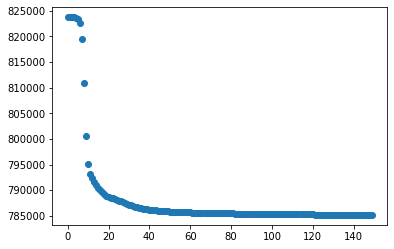

In [5]:
############################################
# Tunable parameters (you will add more)
############################################

nDims = 5

lambda_1 = 0.1
lambda_2 = 0.1
lambda_3 = 10
lambda_4 = 10

############################################
# Initialize parameters
############################################

mu = np.mean(train_rating)
a = np.zeros(nUsers)
b = np.zeros(nMovies)
U = np.random.randn(nUsers, nDims) * .01  # User weights
V = np.random.randn(nMovies, nDims) * .01  # Movie features

############################################
# Training and validation
############################################

alpha = 0.01
iters = 150

J_history = [0 for _ in range(iters)]

for iter in range(iters):

   for k, r_ix in enumerate(train_rating):
      i, x = train_movie[k], train_user[k]
      a_x = a[x]
      b_i = b[i]
      q_i = V[i]
      p_x = U[x]

      err = r_ix - (mu + a_x + b_i + np.dot(q_i, p_x))

      a[x] = a_x - alpha * (-2 * err + 2 * lambda_3 * a_x)
      b[i] = b_i - alpha * (-2 * err + 2 * lambda_4 * b_i)
      V[i] = q_i - alpha * (-2 * err * p_x + 2 * lambda_1 * q_i)
      U[x] = p_x - alpha * (-2 * err * q_i + 2 * lambda_2 * p_x)

   J_history[iter] = cost_function(train_rating, U, V, lambda_1, lambda_2)

print("final cost: ", cost_function(train_rating, U, V, lambda_1, lambda_2))
plt.scatter(range(iters), J_history)
plt.show()

In [9]:
train_predictions = predict(mu, train_user, train_movie)
valid_predictions = predict(mu, valid_user, valid_movie)

print(train_predictions, train_rating)

train_rmse = rmse(train_predictions, train_rating)
valid_rmse = rmse(valid_predictions, valid_rating)

print('train_rmse=%.3f, valid_rmse=%.3f' % (train_rmse, valid_rmse))

############################################
# Testing
############################################

# Make and save predictions for test set
test_predictions = predict(mu, test_user, test_movie)
np.savetxt('test_predictions.txt', test_predictions)
np.savetxt('d.txt', [nDims])
np.savetxt('mu.txt', [mu])
np.savetxt('u.txt', U)
np.savetxt('v.txt', V)
np.savetxt('a.txt', a)
np.savetxt('b.txt', b)

[3.59058602 3.85406441 2.45302439 ... 4.54547534 4.15502628 3.54059859] [4 4 3 ... 5 1 3]
train_rmse=0.790, valid_rmse=0.950


## Bonus Material: Inspect Predictions for Different Users

After you have learned a good model, you may wish to interpret what it has learned. We can do this by looking at the most positive and most negative predictions for different users
(or the movies that are bumped up or down from the baseline the most).

Read and run the code below to see if you can understand the predictions. (Note: the predictions won't make sense until you have learned a good model!)


In [10]:
all_movies = range(nMovies)


def get_lowest(vals):
    most_negative = np.argsort(vals)
    return most_negative


def get_highest(vals):
    most_negative = np.argsort(vals)
    most_positive = most_negative[::-1]
    return most_positive


k = 8
all_users = range(nUsers)
users_to_examine = all_users[0:5]

for user in users_to_examine:

    # Changes from baseline movie predictions for this user
    delta = np.dot(V, U[user, :])

    print('*** User %d ***' % (user))
    print('  Top movies')
    for i in get_highest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')

    print('  Bottom movies')
    for i in get_lowest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')


*** User 0 ***
  Top movies
    +1.3545  Maya Lin: A Strong Clear Vision (1994)
    +1.3061  Wallace & Gromit: The Best of Aardman Animation (1996)
    +1.2943  Paths of Glory (1957)
    +1.2533  Big Lebowski, The (1998)
    +1.2524  Saint of Fort Washington, The (1993)
    +1.2325  Kaspar Hauser (1993)
    +1.2316  Wrong Trousers, The (1993)
    +1.1870  Ghost in the Shell (Kokaku kidotai) (1995)

  Bottom movies
    -2.5442  Free Willy 3: The Rescue (1997)
    -2.3746  Simple Wish, A (1997)
    -2.3705  Showgirls (1995)
    -2.2924  Original Gangstas (1996)
    -2.2577  Jack and Sarah (1995)
    -2.1824  Pest, The (1997)
    -2.1628  Amityville II: The Possession (1982)
    -2.1412  Home Alone 3 (1997)

*** User 1 ***
  Top movies
    +1.4201  Delta of Venus (1994)
    +1.4139  Bread and Chocolate (Pane e cioccolata) (1973)
    +1.3489  Pather Panchali (1955)
    +1.3205  Ruling Class, The (1972)
    +1.3093  They Made Me a Criminal (1939)
    +1.2671  Casablanca (1942)
    +1.2601  

## More Bonus Material: Interpretation of Weight Vectors as Features

- So far we have described both $u_i$ and $v_j$ as _weight vectors_ (since we don't have any features of movies and users). But, it is possible to interpret one or both of these vectors as **learned features**.

- For example, the first learned feature may discover a preference for comedy vs. drama. In this case:
  - The user feature value $u_{i1}$ should be high if the user likes comedies and low if the user likes dramas better.
  - The movie feature value $v_{j1}$ should be high if the movie is a comedy and low if it is a drama.
- Similarly, feature 2 might describe whether a movie is geared toward kids or adults

- In practice, the feature interpretations often find recognizable patterns but are not quite so clean to describe as the two examples above.

Run the code below to examine the movies with the highest and lowest feature values for some of the features in your learned model.


In [11]:
k = 5

features_to_examine = np.arange(0, nDims)

for feature in features_to_examine:

    feature_vals = V[:, feature]

    print('*** Feature %d ***' % (feature))
    print('  Movies with highest feature value')
    for i in get_highest(feature_vals)[0:k]:
        print('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print('')

    print('  Movies with lowest feature value')
    for i in get_lowest(feature_vals)[0:k]:
        print('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print('')


*** Feature 0 ***
  Movies with highest feature value
    +1.2044  Mostro, Il (1994)
    +1.1609  Girl in the Cadillac (1995)
    +1.1137  Sum of Us, The (1994)
    +1.0947  Picture Bride (1995)
    +1.0404  Angel Baby (1995)

  Movies with lowest feature value
    -1.6198  Stupids, The (1996)
    -1.5392  Endless Summer 2, The (1994)
    -1.5151  Carried Away (1996)
    -1.5146  Baby-Sitters Club, The (1995)
    -1.4739  Phat Beach (1996)

*** Feature 1 ***
  Movies with highest feature value
    +1.9352  Home Alone 3 (1997)
    +1.7678  Wild Things (1998)
    +1.6381  Bio-Dome (1996)
    +1.6337  Vampire in Brooklyn (1995)
    +1.5825  Lost in Space (1998)

  Movies with lowest feature value
    -1.4549  Delta of Venus (1994)
    -1.4096  Bread and Chocolate (Pane e cioccolata) (1973)
    -1.3232  Aparajito (1956)
    -1.2690  Carried Away (1996)
    -1.2689  Ruling Class, The (1972)

*** Feature 2 ***
  Movies with highest feature value
    +1.6366  Boys, Les (1997)
    +0.9906  New